In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.22-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [2]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# get the data
filname = 'drive/facial-recognition/fer2013.csv'
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']
df = pd.read_csv('drive/facial-recognition/fer2013.csv',names=names, na_filter=False)
im=df['pixels']
df.head(10)

,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [5]:
def getData(filname):
    # images are 48x48
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y

In [6]:
X, Y = getData(filname)
num_class = len(set(Y))
print(num_class)

7


In [7]:
# keras with tensorflow backend
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

In [90]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

In [91]:
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization


In [159]:
def my_model():
    model = Sequential()
    input_shape = (48,48,1)
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    
    return model

In [160]:
model=my_model()
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_108 (Bat (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 24, 24, 128)       409728    
_________________________________________________________________
batch_normalization_109 (Bat (None, 24, 24, 128)     

In [163]:
path_model='drive/facial-recognition/model_filter.h5' 
model=my_model()

In [164]:
model.load_weights(path_model)

In [150]:
opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [165]:
model.evaluate(X_test, y_test)

113/113 [==============================] - 88s 776ms/step - loss: 2.2567 - accuracy: 0.6163


[2.2566702365875244, 0.6163276433944702]

In [166]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
y_pos = np.arange(len(objects))
print(y_pos)

[0 1 2 3 4 5 6]


In [167]:
def emotion_analysis(emotions):
    objects = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
plt.show()

In [168]:
y_pred=model.predict(X_test)
#print(y_pred)
y_test.shape

(3589, 7)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


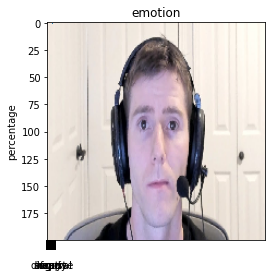

Expression Prediction: sad


In [170]:
from skimage import io
img = image.load_img('drive/random-guy.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('drive/random-guy.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


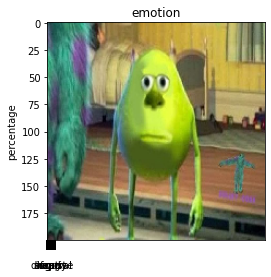

Expression Prediction: angry


In [171]:
from skimage import io
img = image.load_img('/content/drive/kappa.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('/content/drive/kappa.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])